# Determining Euler's tour (Fleury's algorithm and via DFS)

This is a project that implements a Graph class with methods for finding an Eulerian Tour using two different approaches: 

1. Fleury's Algorithm (which validates edges by checking for bridges);
2. DFS-based approach (Hierholzer's Algorithm, which is more efficient).

Fleury's algorithm - a graph theory method to find an Eulerian path or circuit (using every edge exactly once) by starting at an appropriate vertex (odd degree for path, any for circuit) and traversing edges, crucially never choosing a bridge (an edge whose removal disconnects the graph) unless there's no other option, ensuring the entire graph remains traversable until all edges are used. 


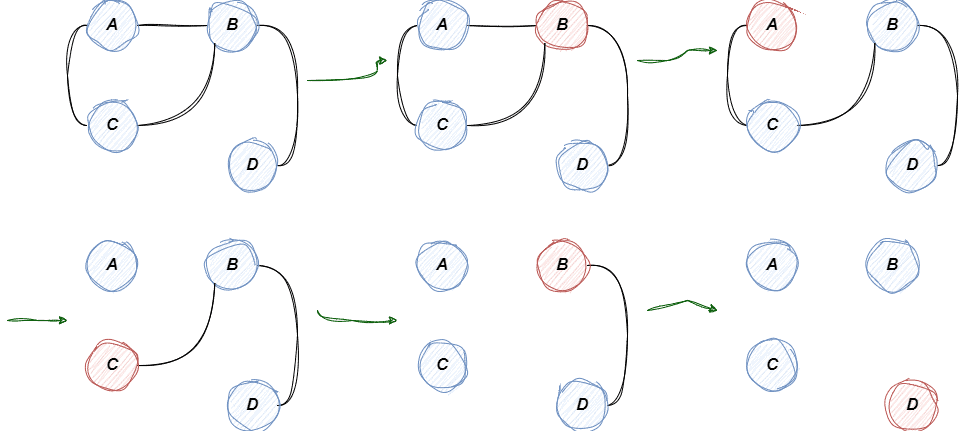 once.

Hierholzer's Algorithm - efficiently finds Eulerian paths (or circuits) in graphs by traversing edges and splicing together sub-tours, working in O(E) time; it starts at an odd-degree vertex (for paths) or any vertex (for circuits), follows unused edges until stuck (forming a cycle), then backtracks to find unvisited edges from vertices on the current tour, recursively merging these new cycles until all edges are used, creating the complete Eulerian path/circuit.


## Libraries

In [111]:
import sys
from collections import defaultdict
import copy
import networkx as nx
import matplotlib.pyplot as plt

## Class Graph

In [113]:
class Graph:
    def __init__(self, vertices):
        self.V = vertices
        #Using a dictionary of lists for adjacency
        self.graph = defaultdict(list)

    def add_edge(self, u, v):
        """Adds an undirected edge to the graph."""
        self.graph[u].append(v)
        self.graph[v].append(u)

    def remove_edge(self, u, v):
        """Removes an edge (used for Fleury's)."""
        if v in self.graph[u]:
            self.graph[u].remove(v)
        if u in self.graph[v]:
            self.graph[v].remove(u)

    #Check if Eulerian tour

    def is_eulerian(self):
        """
        Checks if the graph has an Eulerian Tour.
        Condition: Graph is connected (ignoring isolated vertices) 
        and every vertex has an even degree.
        """
        #Checking Connectivity
        visited = [False] * self.V
        
        #Finding a node with non-zero degree to start traversal
        start_node = -1
        for i in range(self.V):
            if len(self.graph[i]) > 0:
                start_node = i
                break
        
        if start_node == -1:
            return True #Empty graph is technically Eulerian

        self._dfs_count(start_node, visited)

        #Checking if all non-zero degree vertices are visited
        for i in range(self.V):
            if len(self.graph[i]) > 0 and not visited[i]:
                return False

        #Checking degrees (all must be even)
        for i in range(self.V):
            if len(self.graph[i]) % 2 != 0:
                return False

        return True

    def _dfs_count(self, v, visited):
        """Standard DFS helper."""
        visited[v] = True
        for i in self.graph[v]:
            if not visited[i]:
                self._dfs_count(i, visited)

    """
    Algorithm 1: Fleury's Algorithm
    Complexity: O(E^2) - Slow due to bridge check
    """
    def get_fleury_tour(self):
        """Wrapper to run Fleury's without destroying original graph."""
        if not self.is_eulerian():
            return "Graph is not Eulerian tour (Odd degrees or disconnected)."
        
        #Create a deep copy because Fleury's is destructive
        temp_graph = copy.deepcopy(self)
        
        #Find start node (any node with edges)
        start_node = 0
        for i in range(self.V):
            if len(self.graph[i]) > 0:
                start_node = i
                break
                
        path = []
        temp_graph._fleury_recursive(start_node, path)
        return path

    def _fleury_recursive(self, u, path):
        path.append(u)
        
        #Iterate over a copy of neighbors since we modify the list
        for v in list(self.graph[u]):
            if self._is_valid_next_edge(u, v):
                self.remove_edge(u, v)
                self._fleury_recursive(v, path)
                break

    def _is_valid_next_edge(self, u, v):
        """
        The core logic of Fleury's:
        1. If v is the only neighbor, it's valid.
        2. If v is not the only neighbor, checks if u-v is a bridge.
           Don't cross a bridge unless necessary.
        """
        #If this is the only edge, it must be picked
        if len(self.graph[u]) == 1:
            return True

        #Counting reachable nodes with the edge
        visited = [False] * self.V
        count1 = self._count_reachable(u, visited)

        #Removing edge temporarily and counting reachable nodes
        self.remove_edge(u, v)
        visited = [False] * self.V
        count2 = self._count_reachable(u, visited)

        #Adding edge back
        self.add_edge(u, v)

        # If count1 > count2, then removing the edge disconnected components,
        # making it a bridge. It is prefered NOT to cross bridges.
        return count1 <= count2

    def _count_reachable(self, v, visited):
        count = 1
        visited[v] = True
        for i in self.graph[v]:
            if not visited[i]:
                count += self._count_reachable(i, visited)
        return count

    """
    Algorithm 2: DFS Based (Hierholzer's Algorithm)
    Complexity: O(E) - Linear and efficient
    """
    def get_dfs_tour(self):
        """
        Finds Eulerian path using Hierholzer's algorithm logic 
        implemented via a stack (DFS).
        """
        if not self.is_eulerian():
            return "Graph is not Eulerian tour."

        #Coping adjacency list to track used edges efficiently
        adj = copy.deepcopy(self.graph)
        
        #Finding start node
        start_node = 0
        for i in range(self.V):
            if len(adj[i]) > 0:
                start_node = i
                break

        #Stack for DFS, Path for final circuit
        stack = [start_node]
        circuit = []

        while stack:
            u = stack[-1]
            
            #If u has neighbors, follow the edge
            if adj[u]:
                v = adj[u].pop() # Take a neighbor

                """
                Remove u from v's list (undirected removal)
                Note: In optimized Hierholzer, we usually just pop one way
                but since this is undirected, we must ensure we don't traverse back immediately
                """
                if u in adj[v]:
                    adj[v].remove(u)
                
                stack.append(v)
            else:
                #If no neighbors left, backtrack and add to circuit
                circuit.append(stack.pop())

        #The circuit is built in reverse during backtracking
        return circuit[::-1]


## Visualization of the graph

In [115]:
def visualize_graph(g):
    """Visualizes the graph using NetworkX and Matplotlib."""
    try:
        G = nx.Graph()
        for u in g.graph:
            for v in g.graph[u]:
                G.add_edge(u, v)
        
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='lightgreen', 
                node_size=700, font_weight='bold', edge_color='gray')
        plt.title("Graph Visualization")
        plt.show()
    except Exception as e:
        print(f"Visualization skipped: {e}")


## Main execution

Graph Structure (Adjacency List):
0: [1, 2]
1: [0, 2]
2: [1, 0, 3]
3: [2]


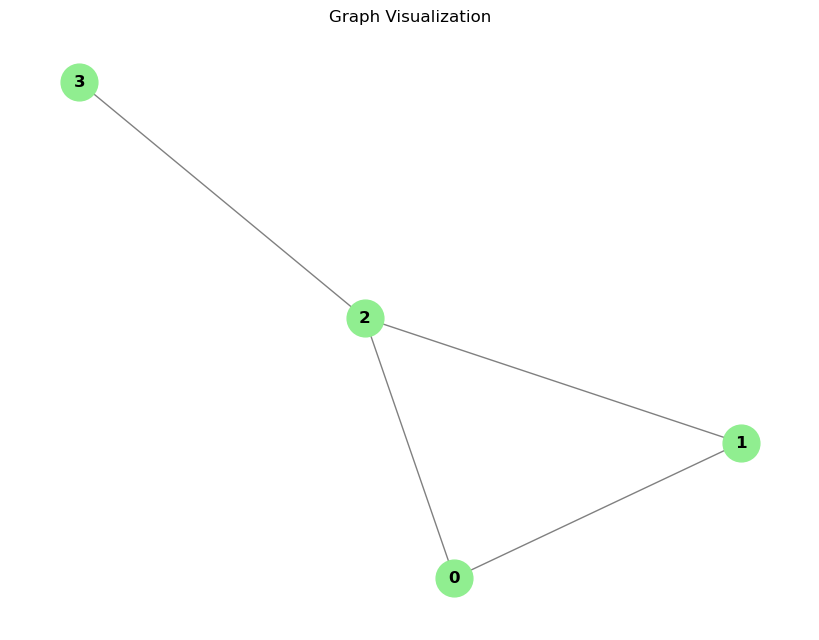

Is Eulerian TOUR? False
Fleury's Tour: Graph is not Eulerian tour (Odd degrees or disconnected).
DFS Tour:      Graph is not Eulerian tour.
------------------------------------------------------------------
Bowtie: Vertices 0,1,2 form one triangle. Vertices 2,3,4 form another.
Graph Structure (Adjacency List):
0: [1, 2]
1: [0, 2]
2: [1, 0, 3, 4]
3: [2, 4]
4: [3, 2]


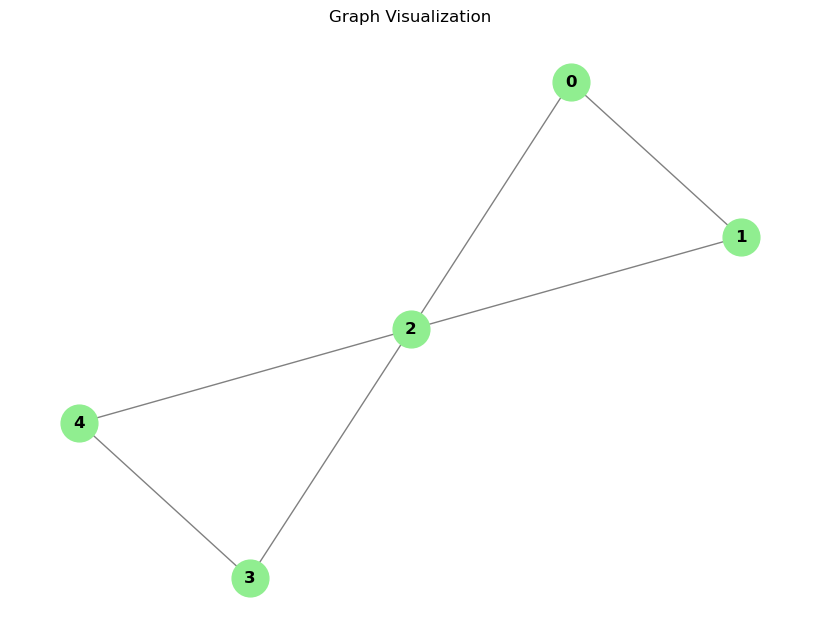

Is Eulerian TOUR? True
Fleury's Tour: [0, 1, 2, 3, 4, 2, 0]
DFS Tour:      [0, 2, 4, 3, 2, 1, 0]
------------------------------------------------------------------
Complete Graph K5
Graph Structure (Adjacency List):
0: [1, 2, 3, 4]
1: [0, 2, 3, 4]
2: [0, 1, 3, 4]
3: [0, 1, 2, 4]
4: [0, 1, 2, 3]


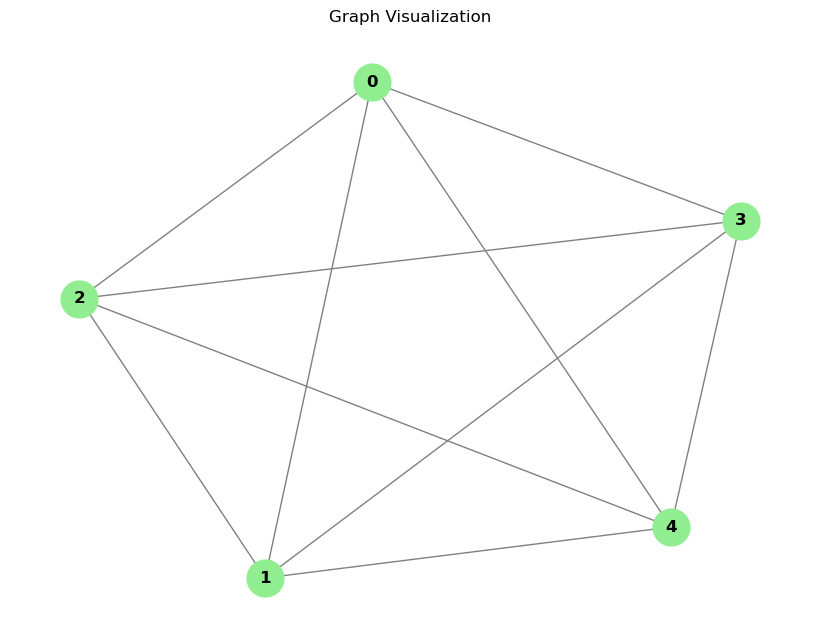

Is Eulerian TOUR? True
Fleury's Tour: [0, 1, 2, 0, 3, 1, 4, 2, 3, 4, 0]
DFS Tour:      [0, 4, 3, 2, 4, 1, 3, 0, 2, 1, 0]
------------------------------------------------------------------
Disconnected Graph
Graph Structure (Adjacency List):
0: [1, 2]
1: [0, 2]
2: [1, 0]
3: [4, 5]
4: [3, 5]
5: [4, 3]


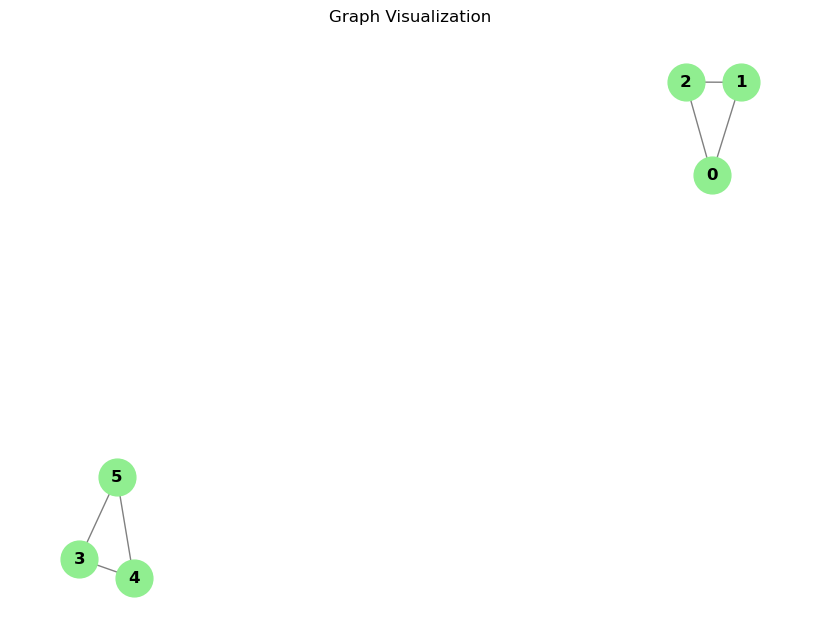

Is EulerianTOUR? False


In [117]:
if __name__ == "__main__":
    
    #Odd Degrees
    g = Graph(4)
    g.add_edge(0, 1)
    g.add_edge(1, 2)
    g.add_edge(2, 0)
    g.add_edge(2, 3)
 
    print("Graph Structure (Adjacency List):")
    for k, v in g.graph.items():
        print(f"{k}: {v}")
    
    visualize_graph(g)
    print(f"Is Eulerian TOUR? {g.is_eulerian()}")

    if g_bowtie.is_eulerian():
        print(f"Fleury's Tour: {g.get_fleury_tour()}")
        print(f"DFS Tour:      {g.get_dfs_tour()}")
    else:
        print("Cannot find tour.")

    print("------------------------------------------------------------------")
    print("Bowtie: Vertices 0,1,2 form one triangle. Vertices 2,3,4 form another.")

    g_bowtie = Graph(5)
    g_bowtie.add_edge(0, 1)
    g_bowtie.add_edge(1, 2)
    g_bowtie.add_edge(2, 0)
    g_bowtie.add_edge(2, 3)
    g_bowtie.add_edge(3, 4)
    g_bowtie.add_edge(4, 2)

    print("Graph Structure (Adjacency List):")
    for k, v in g_bowtie.graph.items():
        print(f"{k}: {v}")
        
    visualize_graph(g_bowtie)

    print(f"Is Eulerian TOUR? {g_bowtie.is_eulerian()}")

    if g_bowtie.is_eulerian():
        print(f"Fleury's Tour: {g_bowtie.get_fleury_tour()}")
        print(f"DFS Tour:      {g_bowtie.get_dfs_tour()}")
    else:
        print("Cannot find tour.")

    print("------------------------------------------------------------------")
    print("Complete Graph K5")

    g_k5 = Graph(5)

    # Connect every node to every other node
    for i in range(5):
        for j in range(i + 1, 5):
            g_k5.add_edge(i, j)

    print("Graph Structure (Adjacency List):")
    for k, v in g_k5.graph.items():
        print(f"{k}: {v}")
    visualize_graph(g_k5)

    print(f"Is Eulerian TOUR? {g_k5.is_eulerian()}")

    if g_k5.is_eulerian():
        print(f"Fleury's Tour: {g_k5.get_fleury_tour()}")
        print(f"DFS Tour:      {g_k5.get_dfs_tour()}")
    else:
        print("Cannot find tour.")


    print("------------------------------------------------------------------")
    print("Disconnected Graph")
    g_disconnected = Graph(6)

    g_disconnected.add_edge(0, 1)
    g_disconnected.add_edge(1, 2)
    g_disconnected.add_edge(2, 0)
    g_disconnected.add_edge(3, 4)
    g_disconnected.add_edge(4, 5)
    g_disconnected.add_edge(5, 3)

    print("Graph Structure (Adjacency List):")
    for k, v in g_disconnected.graph.items():
        print(f"{k}: {v}")
        
    visualize_graph(g_disconnected)

    print(f"Is EulerianTOUR? {g_disconnected.is_eulerian()}")

Fleury’s algorithm, while reliable, may not always be the fastest option. It competes with other algorithms for finding Eulerian paths and circuits. Its efficiency shines in dense graphs, but for sparse graphs, Hierholzer’s algorithm might be faster. Other algorithms, like the Depth-First Search (DFS) method, offer additional options for solving similar problems, each with its advantages and use cases. Choosing the most suitable method depends on the specific characteristics of the graph and the problem at hand.